# Unsupervised classification (via Gaussian Mixture Model) of CRB geochem

In [332]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_completeness_v_measure
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from scipy import mean
from sklearn.mixture import GaussianMixture
import itertools

from sklearn import mixture
import pickle
import sys
import importlib

sys.path.append('../../scripts/')
# Contains special functions used in the script
import GeochemFunctions as geofctns
importlib.reload(geofctns)
import GeochemPlotting as geoplots
importlib.reload(geoplots)


<module 'GeochemPlotting' from '/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB/../../scripts/GeochemPlotting.py'>

## Load data

In [333]:
############# CRB DATAFRAME UPDATED
#NOTE: the "Umtanum" member class has been dropped from this version
path = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_dataframe_completed_2024_V2.csv'
data_=pd.read_csv(path, header=0)

features_sorted = data_.sort_values(["MemberID"], ascending=True)

#############################################
######### Here is where we decide what elements/ features to classify on

#this one maximizes the number of samples
#features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3','Y','V', 'Nb', 'Ga', 'Cu','Zn', 'Pb', 'La', 'Ce', 'Th', 'U', 'Source'])

#this maximizes the accuracy by including more elements, still retaining Indian Ridge member from Reidel (restrictive...)
#features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Ga', 'Cu', 'Zn', 'U', 'Source'])
features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Ga', 'La', 'Ce', 'Zn','Pb','Th', 'U', 'Source'])

features_ = features__.dropna(axis=0, how='any')

#drop the "undifferentiated" member class --- come back to this later?
features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)

#############################################
######### Here is where we decide whether to classify on member vs formation 
#member level
labels= features_.loc[:,'MemberID']

label_names=features_.loc[:,'Member']
IDlabel = 'MemberID'
IDname = 'Member'

#formation level
# labels= features_.loc[:,'FormationID']
# # 0=PGB, 1=Steens, 2=Imnaha, 3=GRB, 4=Wanapum, 5=SMB

# label_names=features_.loc[:,'Formation']
# IDlabel = 'FormationID'
# IDname = 'Formation'

df = features_
labels_df = labels#labelz #labelz is member level
#############################################
#Build lookup table connecting IDs to names of classes
# Find unique class IDs
unique_ID = labels.unique()

NumSamplesPerClass = []
ClassName = []

for value in unique_ID:
    corresponding_class = df[df[IDlabel] == value][IDname].values
    NumSamplesPerClass.append(len(corresponding_class))
    ClassName.append(df[df[IDlabel] == value][IDname].values[0])
    
LookupTable = pd.DataFrame({'MemberID': unique_ID, 'Member': ClassName, 'NumSamples': NumSamplesPerClass})
LookupTable = LookupTable.sort_values(by='MemberID')

print(LookupTable)
#save the features used 
#filename = IDname+'LookupTable.pkl'
#pickle.dump(LookupTable, open(filename, 'wb'))
print(df.columns)
#############################################

df = df.drop(columns=['Member', 'MemberID', 'FormationID', 'Formation', 'Polarity'])

print(df.head(3))

#filename = 'TrainingDataFeatures.pkl' #_maximize_elements
#pickle.dump(df.columns.values, open(filename, 'wb'))
#print(df.columns.values)

#make ratios between every feature and every other feature  
df = pd.DataFrame(geofctns.makeratios(df))

#power transform to normalize values
df = geofctns.normalizedata(df,'powert')

print(np.shape(df))


/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_73453/253909941.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)


    MemberID            Member  NumSamples
0          0       LowerSteens          78
1          1       UpperSteens          32
2          2          LogCreek          20
3          3         FallCreek           8
4          4       AmericanBar          99
5          5         RockCreek          68
6          6      PictureGorge         138
7          7   BuckhornSprings          20
8          8        BirchCreek          38
9          9       TeepeeButte          31
10        10        Rogersburg          23
11        11     SkeletonCreek          38
12        12       CenterCreek          10
13        13      KendrikGrade          27
14        14        BradyGulch          21
15        15       DowneyGulch          59
16        16         FryePoint          17
17        17        ChinaCreek          40
18        18       HoskinGulch          56
19        19  ColdSpringsRidge          74
20        20     MountHorrible          38
21        21    WapshillaRidge         600
22        2

## Fit Gaussian Mixture Model and iterate to find best # clusters

/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_33274/729078838.py:63: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(meanz, v[0], v[1], 180.0 + angle, color=color)


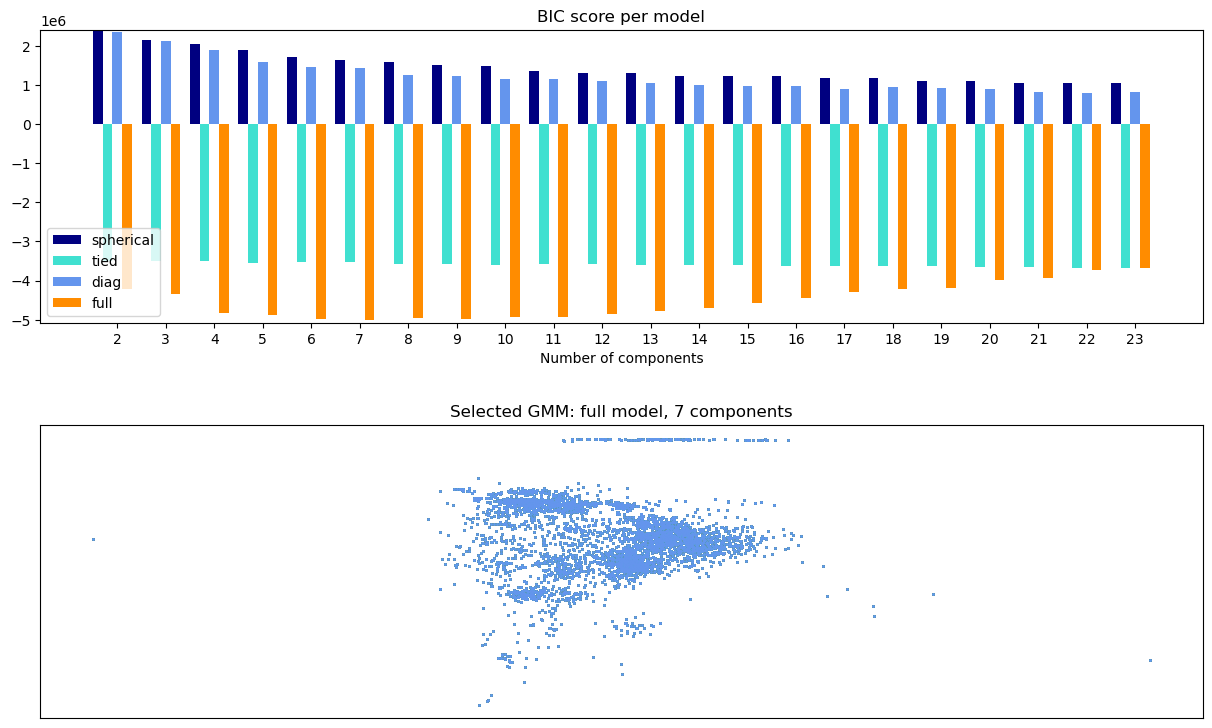

In [11]:
###### Calculate BIC
## This cell compares approaches for covariance - no need to run again, it shows that the approaches result in similar patterns
lowest_bic = np.infty
bic = []
n_components_range = range(2, 15)
cv_types = ["spherical", "tied", "diag", "full"]

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(df)
        bic.append(gmm.bic(df))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
#plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(df)
for i, (meanz, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(df.iloc[:,0], df.iloc[:,1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(meanz, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()


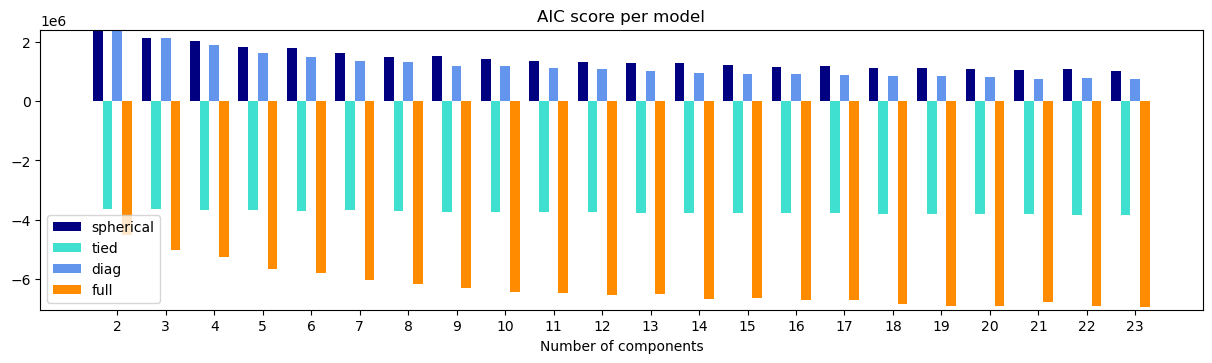

In [12]:
######### Calculate AIC
lowest_aic = np.infty
aic = []
n_components_range = range(2,15)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm2 = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm2.fit(df)
        aic.append(gmm2.aic(df))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm_aic = gmm2

aic = np.array(aic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf2 = best_gmm_aic
bars2 = []

# Plot the AIC scores
plt.figure(figsize=(15, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos2 = np.array(n_components_range) + 0.2 * (i - 2)
    bars2.append(
        plt.bar(
            xpos2,
            aic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - 0.01 * aic.max(), aic.max()])
plt.title("AIC score per model")
xpos2 = (
    np.mod(aic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(aic.argmin() / len(n_components_range))
)
#plt.text(xpos2, aic.min() * 0.97 + 0.03 * aic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)


# Plot the winner
splot2 = plt.subplot(2, 1, 2)
Y_ = clf2.predict(df)
for i, (meand, cov, color) in enumerate(zip(clf2.means_, clf2.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(df.iloc[:,0], df.iloc[:,1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(meand, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm_aic.covariance_type} model, "
    f"{best_gmm_aic.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

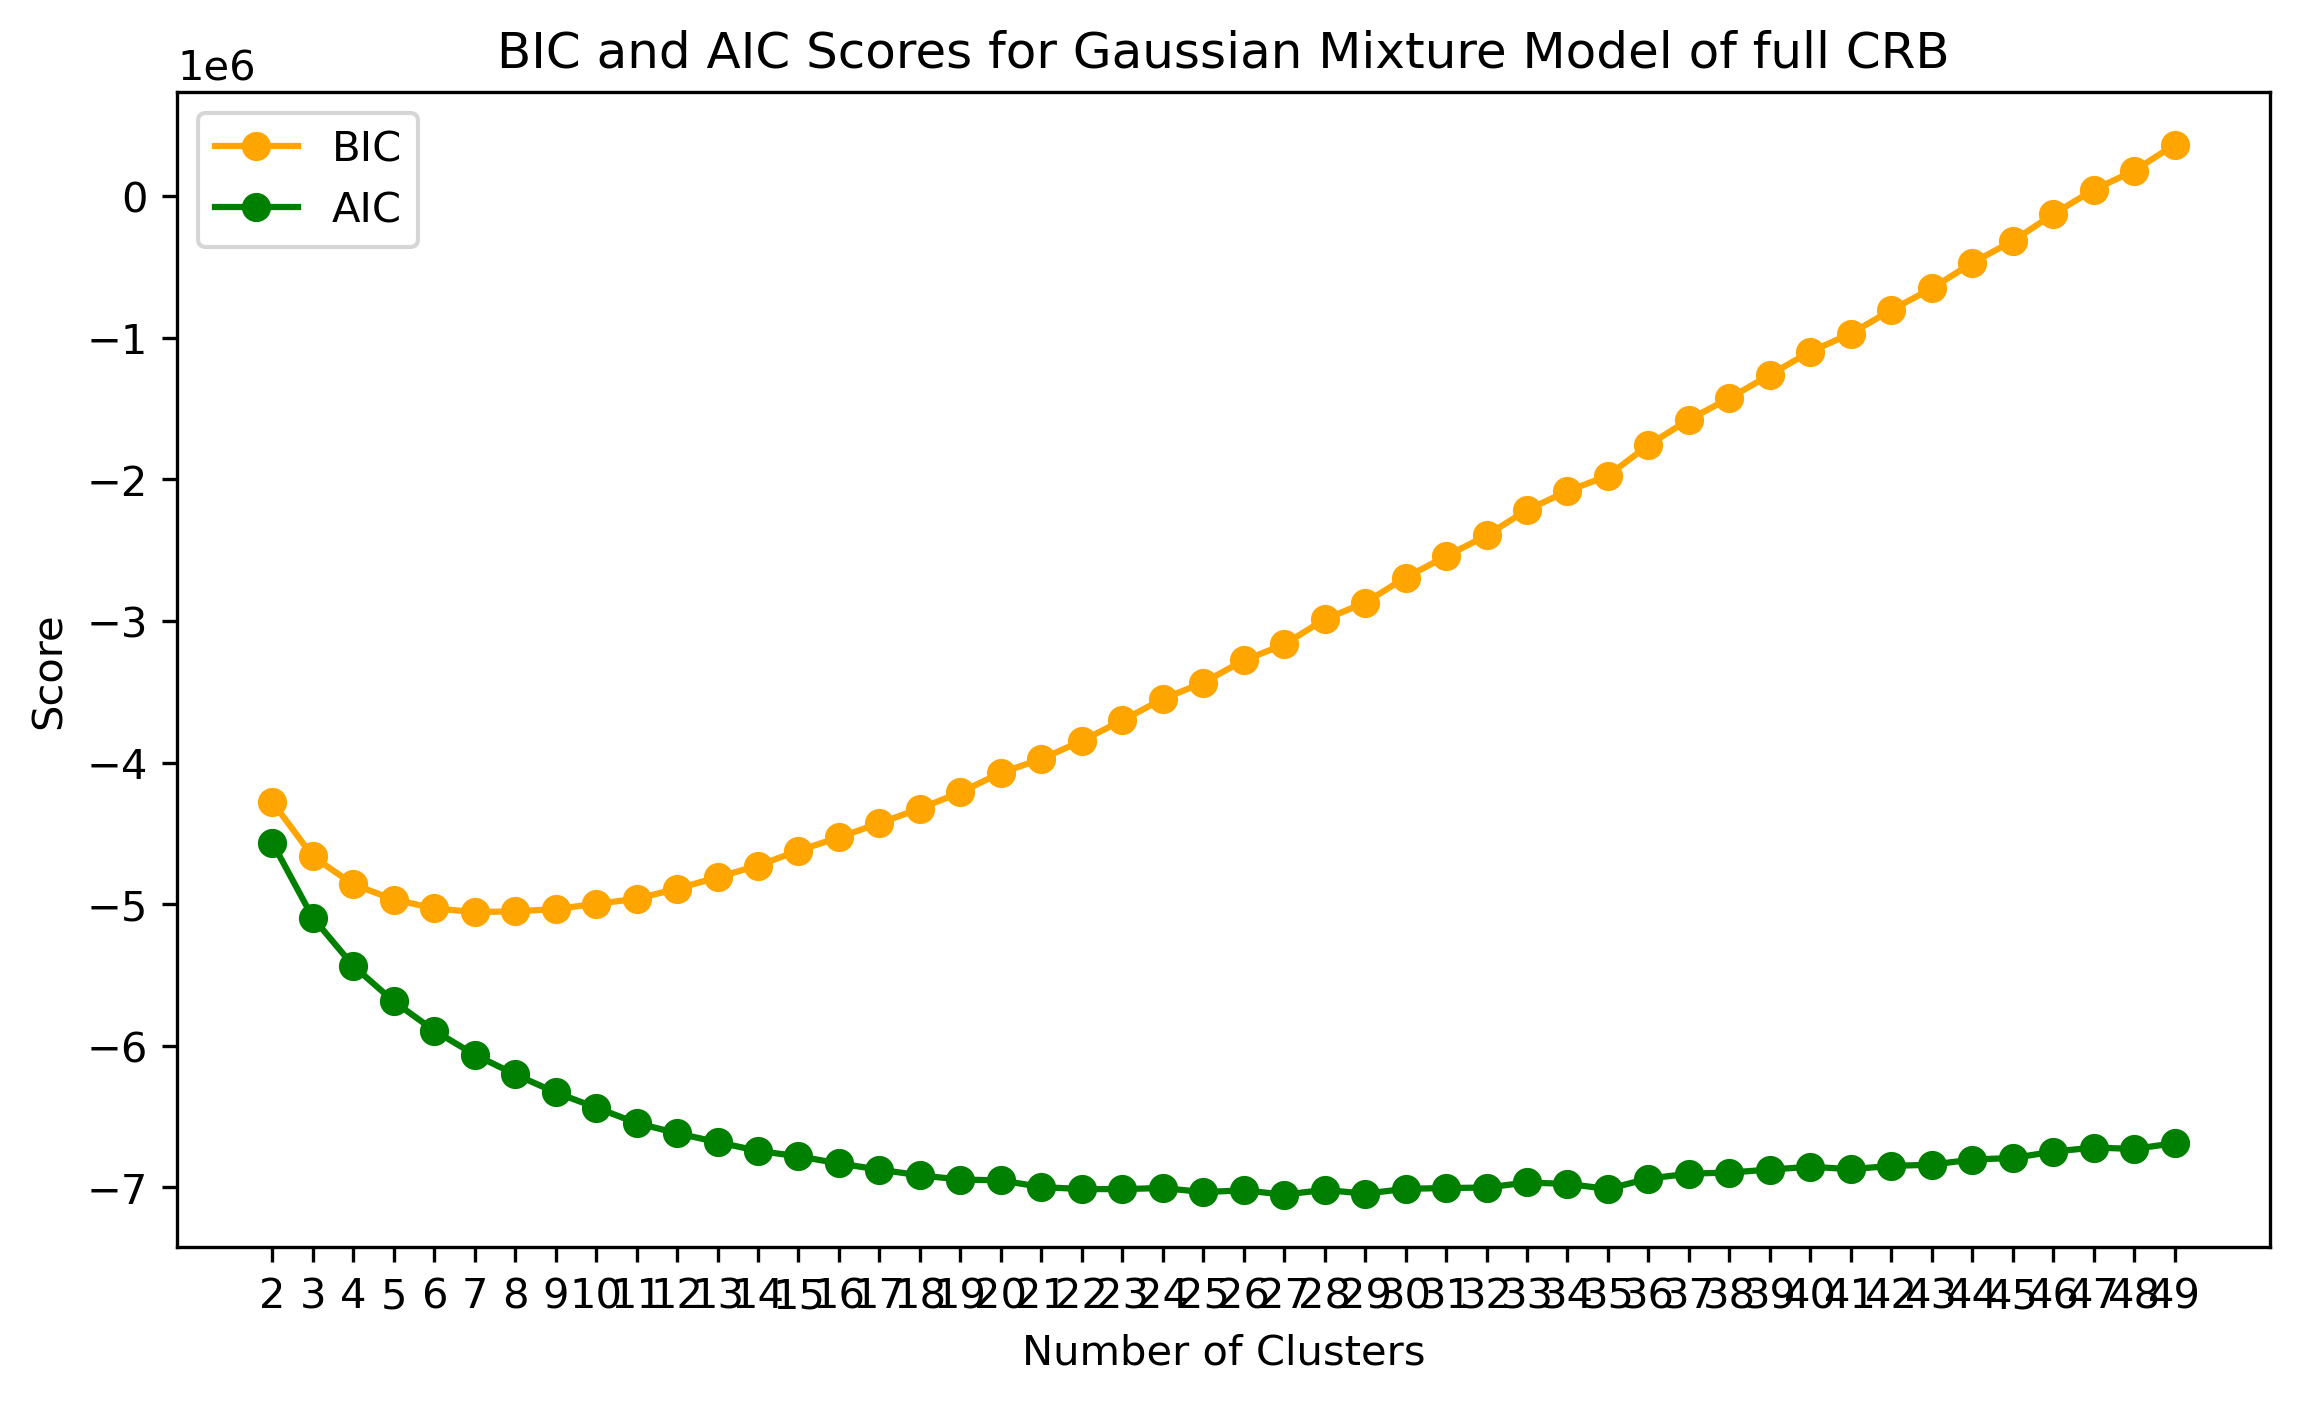

In [58]:
#### USE AIC AND BIC TO FIND APPROPRIATE NUMBER OF CLUSTERS
## !!This can take a long time to run!!

# Set up a range of cluster numbers to try
n_range = range(2,50)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, covariance_type="full",
                         random_state=123, 
                         n_init=50)
    gm.fit(df)
    #gm.fit(df_new)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df))
    aic_score.append(gm.aic(df))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(9,5),nrows=1, dpi=300)
ax.plot(n_range, bic_score, '-o', color='orange', label='BIC')
ax.plot(n_range, aic_score, '-o', color='green', label='AIC')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores for Gaussian Mixture Model of full CRB')
ax.legend()



## Plot up GMM lables versus actual labels, based on assumed # clusters

In [355]:
################## Gaussian Mixture model

data_to_use=df
labels_to_use=labels
n_cluster = 27
random_states=5

## Cluster Original Data
HCV_kmeans_orig=[]
HCV_spec_orig=[]
HCV_agg_orig=[]
HCV_mlr_orig=[]

    
 ###Cluster each data set
SS_kmeans=[]
HCV_kmeans=[]


max_hcv=[]
        
for q in range(random_states):
    y_pred = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=q, n_init=20).fit_predict(data_to_use)

#    Metrics for Clustering on W matrix after decomposition
#            silhouette_avg = silhouette_score(df1, y_pred)
#    print(silhouette_avg)
    hcv=v_measure_score(labels_to_use ,y_pred)
#    print(hcv)
#            SS_kmeans.append(silhouette_avg)
            
    HCV_kmeans.append(hcv)
    silhouette_avg = silhouette_score(data_to_use, y_pred)
    SS_kmeans.append(silhouette_avg)
    
max_HCV = max(HCV_kmeans)  # Find the maximum y value
#        max_RS = range(random_states)[HCV_kmeans.argmax()]  # Find the x value corresponding to the maximum y value
#        print (max_HCV, max_RS)
#max_hcv.append(max_HCV)
print(max_HCV)

max_SScore = max(SS_kmeans)
print(max_SScore)

#minerror = min(Errors2)
max_HCV_pos = HCV_kmeans.index(max_HCV)
hcvmax = range(random_states)[max_HCV_pos]


#### Best Fit Number of Clusters and Best Covariance

y_pred_G = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=hcvmax, n_init=10)
y_pred_g= y_pred_G.fit_predict(data_to_use)


0.709198835638783
0.23984243411611517


/Users/leif/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/leif/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


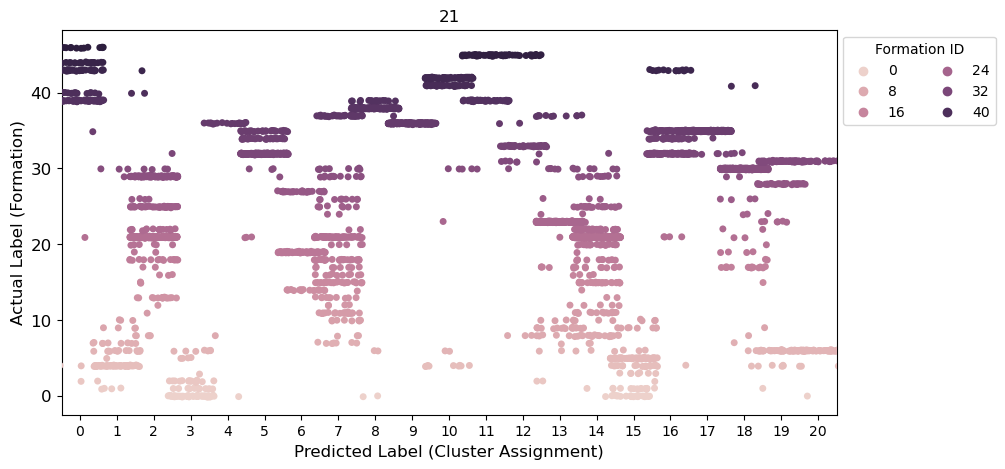

In [356]:
noise = np.random.normal(-.05,.05,4600)
plt.figure(figsize=(10,5))

sns.stripplot(x=y_pred_g, y=labels+noise, hue=labels, jitter=.65)
plt.ylabel('Actual Label (Formation)', fontsize=12);
plt.xlabel('Predicted Label (Cluster Assignment)', fontsize=12);
plt.title(n_cluster, fontsize=12)
sns.color_palette()
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Formation ID', bbox_to_anchor=(1, 1), ncol=2)

## Re-organize and clean up the unsupervised vs supervised plot 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(47, 21) 21
[ 5.  8.  7.  4.  5.  6.  2.  7.  6. 17. 13.  4. 12.  3.  5.  5.  3.  2.
  1.  1.  2.]


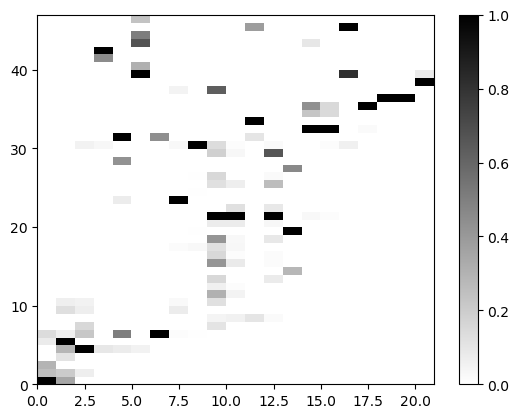

In [357]:
#Nm=np.sum(y_sorted==0)
#plt.hist(x_sorted[0:Nm-1])
UL = y_pred_g#list(ULlabel)
SL = labels#list(SLlabel)

#turn lists into np arrays
ULa=np.asarray(UL)
SLa=np.asarray(SL)

#change this depending on # of labels we decide matter (from AIC/BIC)
NumClust = n_cluster
#this comes from the number of lables in the original data
NumLabel = int(np.amax(labels)+1)
#threshold for what we consider to be a robust correspondence between GMM and original labels
ThreshNum = 2


#test case: find all the points in UL with a given label, 
#then count up how many corresponding values in SL this makes
ID0=np.flatnonzero(ULa == 25)
B = np.arange(0,NumClust+1)
#print(B)
#print(len(B))
#print(ID0)

counts = np.zeros(NumLabel)
#print(len(counts))
for j in range(NumLabel):#range(NumClust):
    counts[j] = np.sum(SLa[ID0]==j)
print(counts)    

#now do this over the whole set of UL labels

#ValArray = np.zeros((NumClust+1, NumClust+1))
ValArray = np.zeros((NumLabel, NumClust))

for i in range(NumClust):
    ID=np.flatnonzero(ULa == i)
    counts = np.zeros(NumLabel)#counts = np.zeros(NumClust+1)
    
    for j in range(NumLabel):#NumClust+1):
        if np.sum(SLa[ID]==j)>ThreshNum:
            counts[j] = np.sum(SLa[ID]==j)

    #counts, binEdges=np.histogram(SLa[ID], bins=B)

    #normalize the counts to make columns comparable
    ValArray[:,i]=counts#/np.amax(counts)
    #MaxInd[i] = np.argmax(counts)
    #MaxV[i] = np.amax(counts)   

print(np.shape(ValArray),NumClust)    
#removed any values for which there is not a SL label    
#ValArray[np.isnan(ValArray)] = 0

#now sort the columns of the histogram array in a recursive manner, 
#mergesort keeps the sorting from previous iteration
#https://opensourceoptions.com/blog/sort-numpy-arrays-by-columns-or-rows/
for i in range(NumLabel):
    I = NumLabel - i#NumClust+1 - i
    if i==0:
        Sorted = ValArray[:,(-ValArray[I-1,:]).argsort()]
        
    else:
        Sorted = Sorted[:,(-Sorted[I-1,:]).argsort(kind='mergesort')]
        

        
SortedNorm = Sorted / np.max(Sorted, axis=0)        

#generate binary array of sorted
binary_array = np.zeros(np.shape(Sorted))
binary_array[Sorted != 0] = 1
        
plt.pcolor((SortedNorm),cmap='binary')
plt.colorbar()

#find the indices of columns in original array
ColumnID = geofctns.find_rows(Sorted.T, ValArray.T)

#print(ColumnID) 
#print(Sorted[:,1],ValArray[:,16])
#print(ColumnID[46][1])
print(np.sum(binary_array,axis=0))
#print(ColumnID)

In [358]:
#now generate a 'new' UL array that 
#assigns the sorted values to appropriate values in Sorted
SortedUL = np.empty(len(UL))
for i in range(len(ULa)):
    for j in range(NumClust):
        if UL[i]==ColumnID[j,1]:
            SortedUL[i]=ColumnID[j,0]
        # if UL[i]==ColumnID[j][1]:
        #     SortedUL[i]=ColumnID[j][0]
    
  

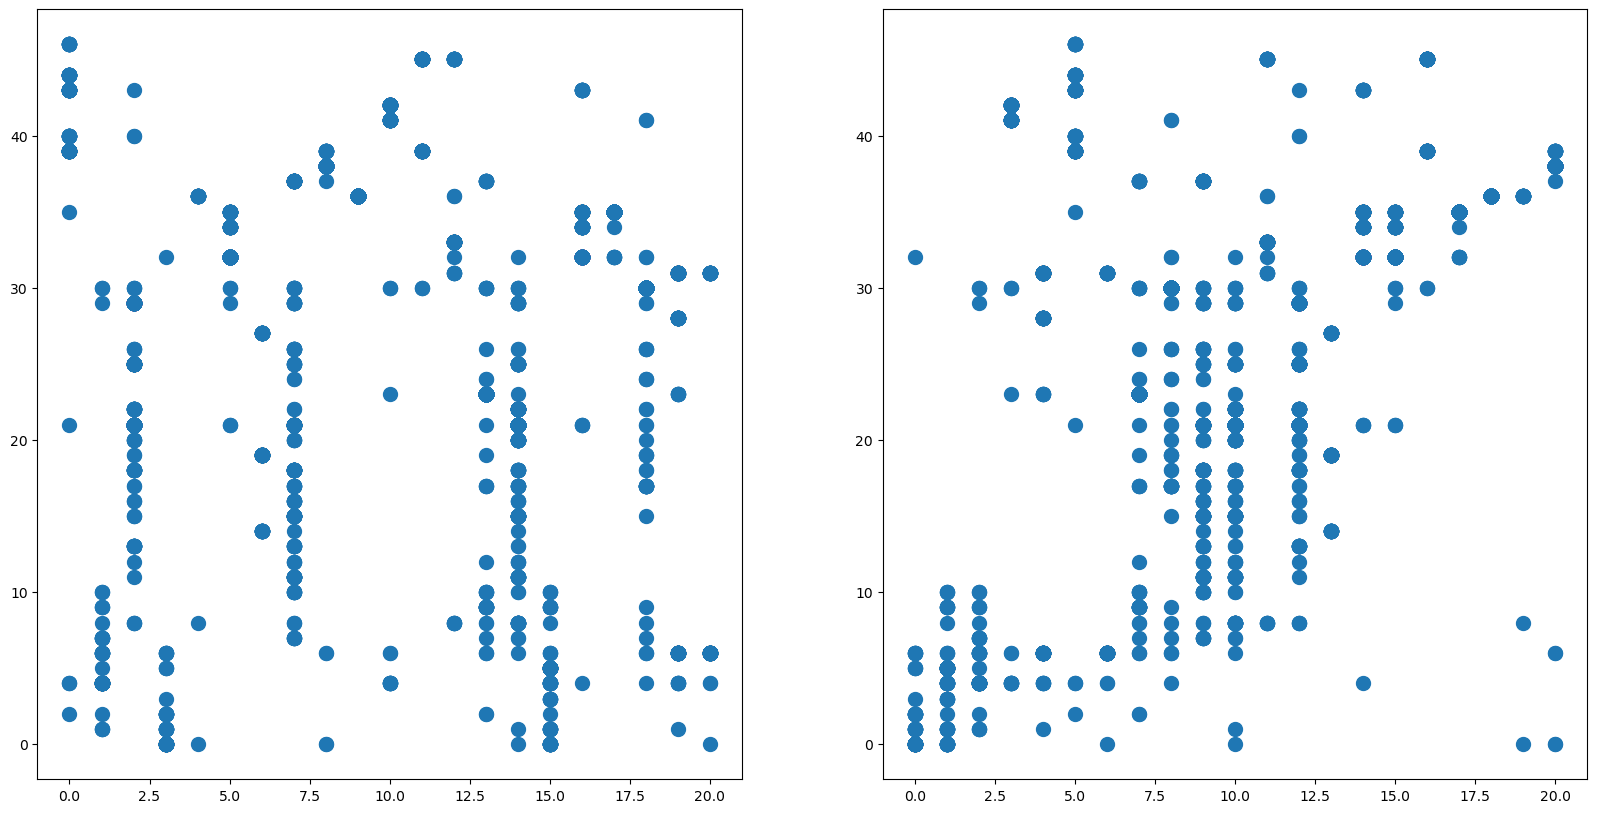

In [359]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.scatter(UL,SL,s=100)
ax2.scatter(SortedUL,SL,s=100)


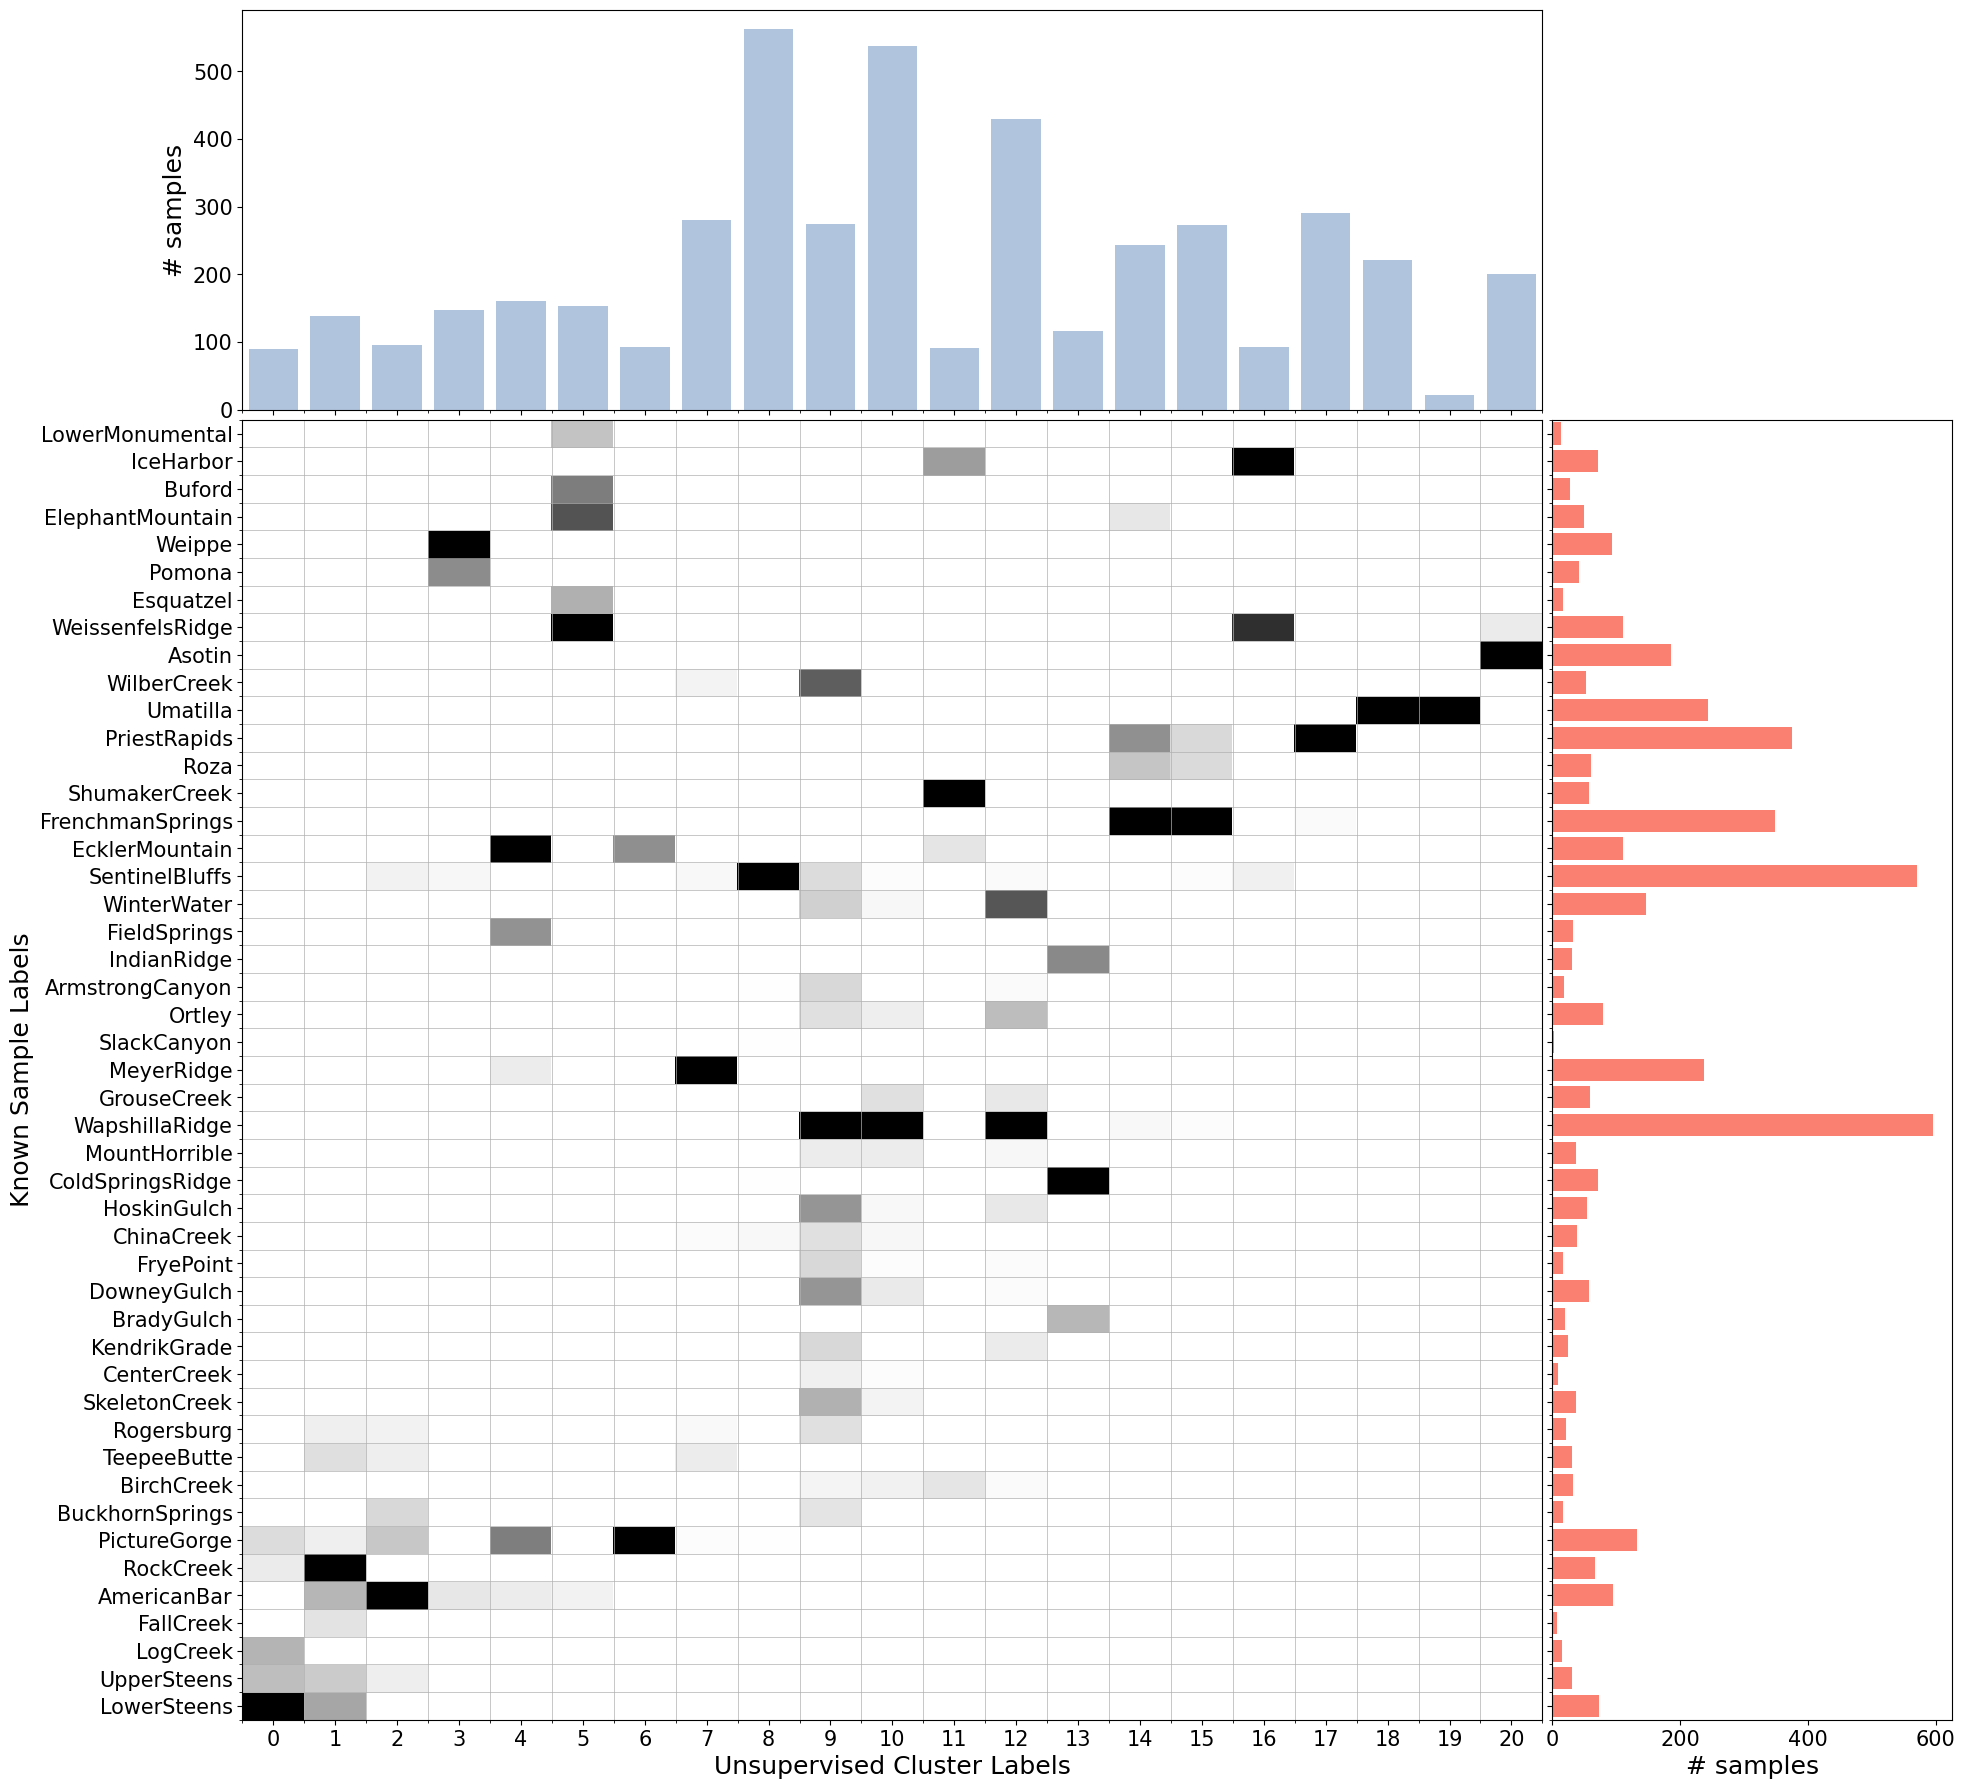

In [360]:
importlib.reload(geoplots)
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

nbins=27

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(20, 20))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
geoplots.pcolor_hist(Sorted, ax, ax_histx, ax_histy,nbins,list(LookupTable.Member))

#geoplots.scatter_hist(SortedUL, SL, ax, ax_histx, ax_histy,nbins,list(LookupTable.Member))

plt.show()

#fig.savefig('CRB_GMM_MemberCompare.pdf')

In [288]:
y = np.sum(Sorted,axis=0)
#len(y)
print(y,len(y),len(SortedUL),len(UL))

[ 408.  464.  519. 1080. 1115.  621.  326.] 7 4600 4600


In [285]:
indices = [i for i, x in enumerate(y_pred_g) if x ==19]
#print(indices)

In [329]:
binary_array = np.zeros(np.shape(SortedNorm))
binary_array[SortedNorm != 0] = 1
binary_array
x = np.sum(binary_array,axis=1)
Sorted

array([[  71.,   28.,    0.,    0.,    0.,    0.,    0.],
       [ 122.,   11.,   32.,   21.,    0.,    0.,    0.],
       [  60.,   64.,    0.,   13.,    0.,    0.,    0.],
       [  80.,    0.,   11., 1003., 1063.,  122.,    0.],
       [  75.,   31.,  328.,    0.,    0.,  459.,   63.],
       [   0.,  341.,  159.,   56.,   52.,   40.,  263.]])